In [178]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn import datasets, linear_model
from tabulate import tabulate
import os

In [179]:
current_path = os.getcwd()
print(current_path)

d:\Work\04Script\01Oceanography\04ApiMarineCopernicus


In [6]:
data = Dataset(r'CMC_1y_current.nc')
lon = data.variables["longitude"][:].filled(np.nan)
lat = data.variables["latitude"][:].filled(np.nan)
vo = data.variables["vo"][:].filled(np.nan)
uo = data.variables ["uo"][:].filled(np.nan)
#zos = data.variables["zos"][:].filled(np.nan)

time = data.variables["time"][:].filled(np.nan)
time_unit = data.variables["time"].getncattr('units')
local_time = num2date(time, units=time_unit,calendar='gregorian')

In [169]:
cur_speed= np.sqrt(uo**2+vo**2)
cur_dir = np.mod((270-np.rad2deg(np.arctan2(vo, uo))),360)

In [23]:
#Coordinate yang mau di Ekstract
ext_lon = 0.9
ext_lat = 104.3

sq_dif_lon = (lon-ext_lon)**2
sq_dif_lat = (lat-ext_lat)**2
index_lon = sq_dif_lon.argmin()
index_lat = sq_dif_lat.argmin()

#print(index_lon, index_lat)

0 31


In [25]:
time_str = []
for x in local_time:
    time_str.append(str(x))
time_list = pd.to_datetime(pd.Series(time_str), format='%Y-%m-%d %H:%M:%S')

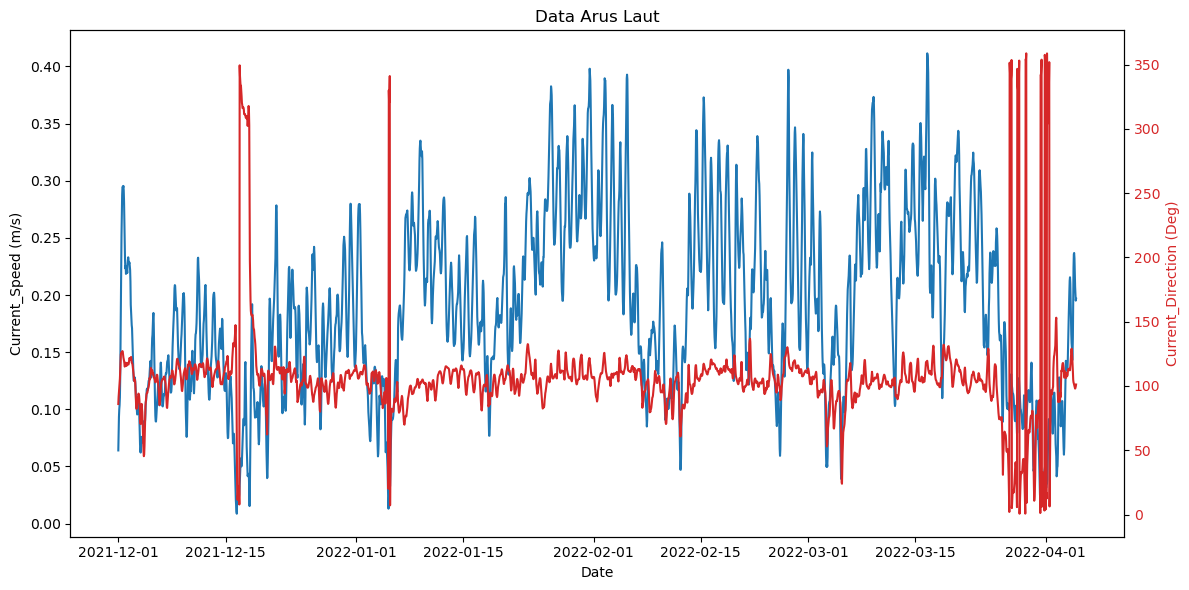

In [65]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Current_Speed (m/s)')
ax1.plot(time_list[0:3000], cur_speed[0:3000,index_lat,index_lon])
ax1.tick_params(axis='y')
ax1.set_title('Data Arus Laut')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Current_Direction (Deg)", color = color)
ax2.plot(time_list[0:3000],cur_dir[0:3000,index_lat,index_lon], color = color)
ax2.tick_params(axis='y', labelcolor = color)

fig.tight_layout()

In [180]:
def convert_csv(dataset, **kwargs):
    """
  Get CSV data from a dataset.
  Args:
    dataset: Set Path to Dataset File (.nc)
    **kwargs: Keyword arguments.
    **Keyword argument:**
    * `coor`: A list of two numbers specifying the [Longitude, Latitude] of the point to get the data for. 
    The coordinates should be in decimal degrees.

  
  Returns:
    A NumPy array containing the CSV data.
  """
    data = Dataset(rf'{dataset}.nc')
    lon = data.variables["longitude"][:].filled(np.nan)
    lat = data.variables["latitude"][:].filled(np.nan)
    vo = data.variables["vo"][:].filled(np.nan)
    uo = data.variables ["uo"][:].filled(np.nan)
    #zos = data.variables["zos"][:].filled(np.nan)

    time = data.variables["time"][:].filled(np.nan)
    time_unit = data.variables["time"].getncattr('units')
    local_time = num2date(time, units=time_unit,calendar='gregorian')

    cur_speed= np.sqrt(uo**2+vo**2)
    cur_dir = np.mod(180+(270-np.rad2deg(np.arctan2(vo, uo))),360)
    ext_lon = kwargs["coor"][0]
    ext_lat = kwargs["coor"][1]

    sq_dif_lon = (lon-ext_lon)**2
    sq_dif_lat = (lat-ext_lat)**2
    index_lon = sq_dif_lon.argmin()
    index_lat = sq_dif_lat.argmin()

    time_str = []
    for x in local_time:
      time_str.append(str(x))
    time_list = pd.to_datetime(pd.Series(time_str), format='%Y-%m-%d %H:%M:%S')

    d = {'Time': time_list, 'Velocity (m/s)': cur_speed[:,index_lon, index_lat], 'Direction(deg)': cur_dir[:,index_lon, index_lat], 'uo': uo[:,index_lon, index_lat], 'vo': vo[:,index_lon, index_lat]}
    df = pd.DataFrame(data = d, index = None)
    df.to_csv(f'Hasil/{dataset}.csv')
    return df


In [329]:
def draw_graph(dataset, coor = [0.9, 104.3], time = False):
    df = convert_csv(dataset, coor = coor)

    if time == False:
        timestep = slice(None)
    else:
        start = time[0] - df['Time'].iloc[0]
        start_time = int(start.total_seconds()/3600)
        end = time[1] - df['Time'].iloc[0]
        end_time = int(end.total_seconds()/3600)
        timestep = slice(start_time,end_time)
    
    print(timestep)
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Current_Speed (m/s)')
    ax1.plot(time_list[timestep], cur_speed[timestep,index_lat,index_lon])
    ax1.tick_params(axis='y')
    ax1.set_title('Data Arus Laut')

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Current_Direction (Deg)", color = color)
    ax2.plot(time_list[timestep],cur_dir[timestep,index_lat,index_lon], color = color)
    ax2.tick_params(axis='y', labelcolor = color)
    
    plt.show()

slice(1488, 2160, None)


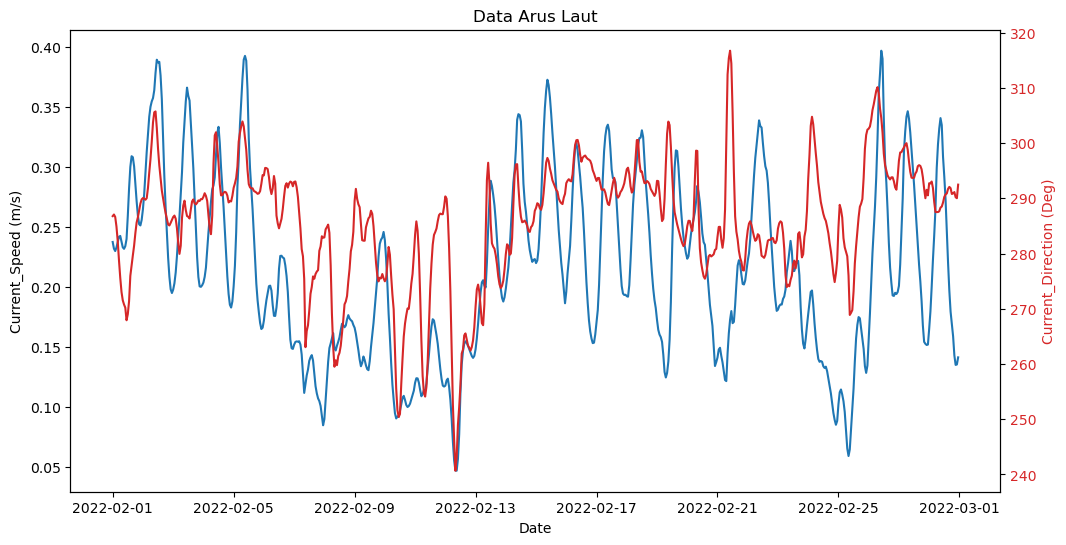

In [330]:
start_time = datetime(2022,2,1,00,00,00)
end_time = datetime(2022,3,1,00,00,00)

draw_graph('CMC_1y_current',coor = [0.9, 104.3], time = [start_time, end_time])

In [320]:
start = datetime(2022,12,1,00,00,00) - df['Time'].iloc[0] 
start_time = start.total_seconds()/3600
int(start_time)

8760

In [276]:
dates = df['Time'].iloc[0] - datetime(2021,3,1,00,00,00) 
print(dates.total_seconds()/3600)

6600.0


In [248]:
start = 9.0
end = 10.0
print(slice(start,end))

slice(9.0, 10.0, cftime.DatetimeGregorian(2022, 12, 31, 0, 0, 0, 0, has_year_zero=False))


In [183]:
df = get_csv('CMC_1y_current',coor = [0.9, 104.3])

In [184]:
df

,Time,Velocity (m/s),Direction(deg),uo,vo
0,2021-12-01 00:00:00,0.067836,196.402893,-0.019156,-0.065075
1,2021-12-01 01:00:00,0.070020,201.446350,-0.025601,-0.065172
2,2021-12-01 02:00:00,0.072392,208.260132,-0.034276,-0.063764
3,2021-12-01 03:00:00,0.076889,214.904907,-0.043997,-0.063057
4,2021-12-01 04:00:00,0.090013,219.168396,-0.056852,-0.069787
...,...,...,...,...,...
9476,2022-12-30 20:00:00,0.191199,169.484009,0.034896,-0.187988
9477,2022-12-30 21:00:00,0.190820,168.743652,0.037248,-0.187150
9478,2022-12-30 22:00:00,0.189251,167.801758,0.039988,-0.184978
9479,2022-12-30 23:00:00,0.185902,166.681885,0.042824,-0.180902
